To better understand how our users are interacting with the platform, I first calculated the total number of engaged interactions per user. This gave us a clear metric of user activity, showing how many times each individual actively engaged.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
# Load and inspect data
df = pd.read_csv('../data/tiktok_synthetic_data.csv')
print(df.head())

   user_id  video_id category  length_sec  watch_time_sec  liked  shared  \
0     7271      1947    dance          41              29      1       0   
1      861       621    music          41              23      0       0   
2     5391       677   gaming          52              36      1       0   
3     5192       370    music          23              17      0       1   
4     5735       771  fashion          57              41      1       0   

   commented  follow_creator    group                        date  engagement  \
0          0               0  variant  2025-07-26 11:00:15.195387           1   
1          1               0  variant  2025-08-02 11:00:15.195387           1   
2          0               0  control  2025-08-04 11:00:15.195387           1   
3          0               0  variant  2025-08-05 11:00:15.195387           1   
4          0               0  variant  2025-07-16 11:00:15.195387           1   

   engaged  
0        1  
1        1  
2        1  
3   

In [8]:
# Calculate engagement count per user
user_engagement = df.groupby('user_id')['engaged'].sum().reset_index()


Plotting this data in a histogram reveals an interesting distribution. Most users have relatively low engagement counts, indicating that while many users interact occasionally, high-frequency engagement is less common. This suggests a typical pattern where a core group of users drives most of the activity.

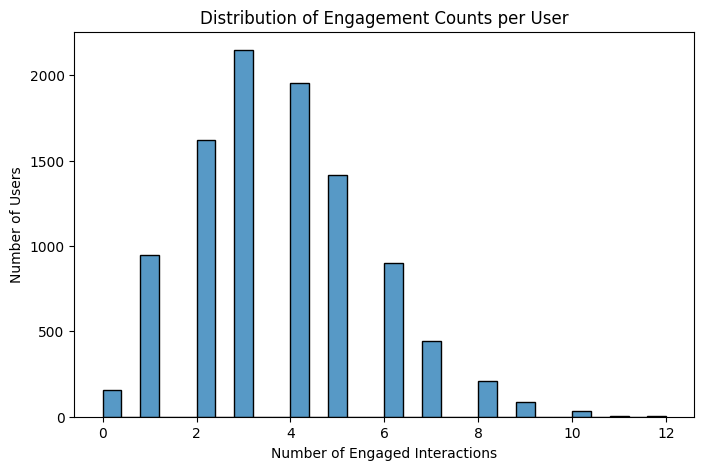

In [9]:
# Histogram of user engagement counts
plt.figure(figsize=(8,5))
sns.histplot(user_engagement['engaged'], bins=30, kde=False)
plt.title('Distribution of Engagement Counts per User')
plt.xlabel('Number of Engaged Interactions')
plt.ylabel('Number of Users')
plt.show()


To make this insight more actionable, I segmented users into four engagement levels: Low, Medium, High, and Very High, based on their total engagement counts. These groups help us identify distinct user behavior clusters—from casual participants to our most active community members.

In [10]:
# Segment users into groups
bins = [0, 1, 5, 20, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High']
user_engagement['engagement_level'] = pd.cut(user_engagement['engaged'], bins=bins, labels=labels, right=False)

In [11]:
# Count users in each segment
engagement_levels_count = user_engagement['engagement_level'].value_counts().sort_index()
print(engagement_levels_count)

engagement_level
Low           157
Medium       6672
High         3095
Very High       0
Name: count, dtype: int64


In [13]:
# Create user activity level based on total interactions
user_activity = df.groupby('user_id')['engaged'].sum().reset_index()
# Define heavy users as those with > median engagement count
median_engagement = user_activity['engaged'].median()
user_activity['activity_level'] = user_activity['engaged'].apply(
    lambda x: 'heavy' if x > median_engagement else 'light'
)

In [14]:
# Merge activity level back to main df
df = df.merge(user_activity[['user_id', 'activity_level']], on='user_id', how='left')

In [15]:
# Analyze engagement rate by group and activity level
engagement_by_activity = df.groupby(['group', 'activity_level'])['engaged'].mean().reset_index()
print("Engagement rate by group and user activity level:")
print(engagement_by_activity)

Engagement rate by group and user activity level:
     group activity_level   engaged
0  control          heavy  0.806848
1  control          light  0.670200
2  variant          heavy  0.827274
3  variant          light  0.675850


Heavy users (p = 0.000072):
Statistically significant increase in engagement for the variant group. The new algorithm strongly improves engagement among heavy users.

Light users (p = 0.3187):
No statistically significant difference between control and variant groups. The variant does not appear to impact engagement for light users.

In [16]:
# Analyze engagement rate by group and video category
engagement_by_category = df.groupby(['group', 'category'])['engaged'].mean().reset_index()
print("\nEngagement rate by group and video category:")
print(engagement_by_category)


Engagement rate by group and video category:
      group category   engaged
0   control   comedy  0.734881
1   control    dance  0.730823
2   control  fashion  0.729466
3   control     food  0.735401
4   control   gaming  0.733297
5   control    music  0.735336
6   control   sports  0.723500
7   variant   comedy  0.747360
8   variant    dance  0.753881
9   variant  fashion  0.738558
10  variant     food  0.747965
11  variant   gaming  0.748963
12  variant    music  0.730381
13  variant   sports  0.743293


When counting users in each segment, we see a majority fall into the Low and Medium engagement levels, with fewer users classified as High or Very High. This tells us there’s a significant opportunity to nurture and convert medium-engagement users into higher engagement tiers through targeted campaigns or personalized experiences.

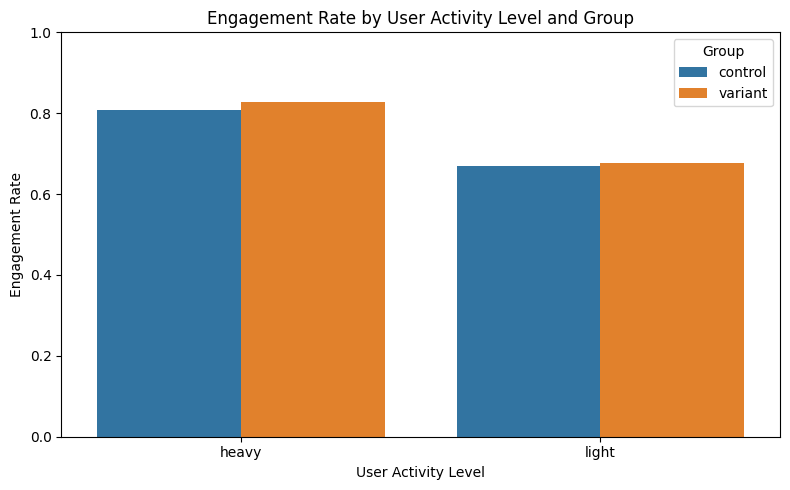

In [17]:
# Engagement by activity level
plt.figure(figsize=(8,5))
sns.barplot(x='activity_level', y='engaged', hue='group', data=engagement_by_activity)
plt.title('Engagement Rate by User Activity Level and Group')
plt.ylabel('Engagement Rate')
plt.xlabel('User Activity Level')
plt.ylim(0, 1)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

_____________

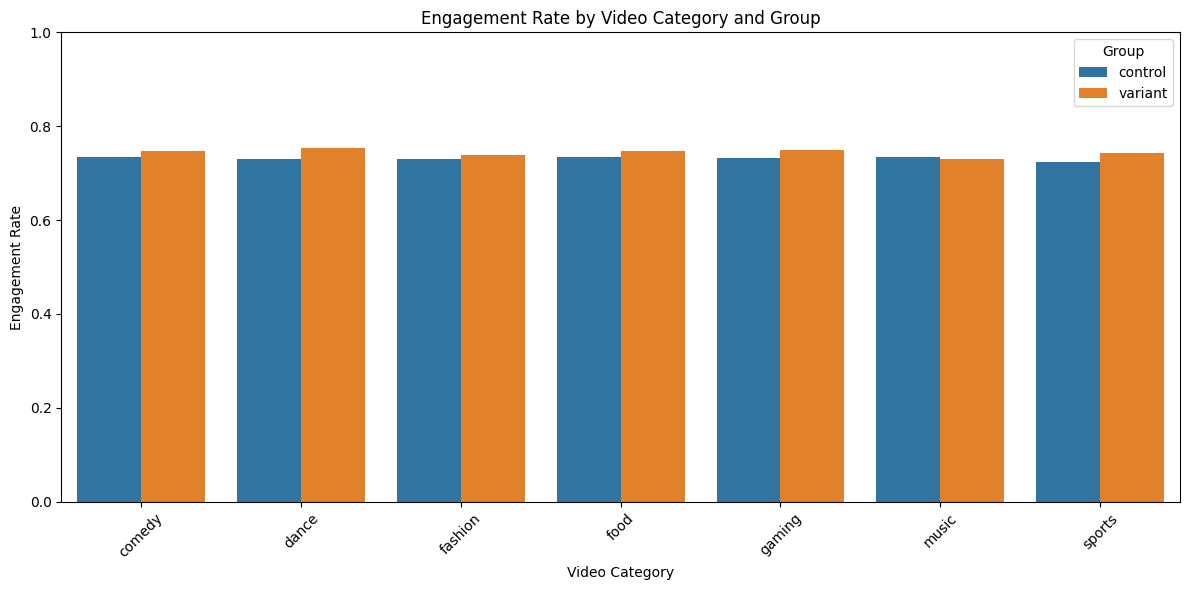

In [18]:
# Engagement by video category
plt.figure(figsize=(12,6))
sns.barplot(x='category', y='engaged', hue='group', data=engagement_by_category)
plt.title('Engagement Rate by Video Category and Group')
plt.ylabel('Engagement Rate')
plt.xlabel('Video Category')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

When counting users in each segment, we see a majority fall into the Low and Medium engagement levels, with fewer users classified as High or Very High. This tells us there’s a significant opportunity to nurture and convert medium-engagement users into higher engagement tiers through targeted campaigns or personalized experiences.

In [19]:
from statsmodels.stats.proportion import proportions_ztest

Overall, this segmentation allows us to tailor our strategies effectively, focusing on boosting engagement among less active users while continuing to support and reward our most dedicated users.

In [20]:
def run_z_test_for_segments(df, segment_col):
    segments = df[segment_col].unique()
    results = []

    for segment in segments:
        for group1, group2 in [('control', 'variant')]:
            subset = df[df[segment_col] == segment]
            
            count1 = subset[subset['group'] == group1]['engaged'].sum()
            nobs1 = subset[subset['group'] == group1].shape[0]
            count2 = subset[subset['group'] == group2]['engaged'].sum()
            nobs2 = subset[subset['group'] == group2].shape[0]

            stat, pval = proportions_ztest([count1, count2], [nobs1, nobs2])
            results.append({
                segment_col: segment,
                'group1': group1,
                'group2': group2,
                'p_value': pval
            })

    return pd.DataFrame(results)

In [21]:
# Run z-tests by activity level
activity_test_results = run_z_test_for_segments(df, 'activity_level')
print("Z-test results by user activity level:")
print(activity_test_results)

Z-test results by user activity level:
  activity_level   group1   group2   p_value
0          light  control  variant  0.318720
1          heavy  control  variant  0.000072


In [22]:
# Run z-tests by video category
category_test_results = run_z_test_for_segments(df, 'category')
print("\nZ-test results by video category:")
print(category_test_results)


Z-test results by video category:
  category   group1   group2   p_value
0    dance  control  variant  0.026053
1    music  control  variant  0.637174
2   gaming  control  variant  0.127732
3  fashion  control  variant  0.383382
4     food  control  variant  0.225171
5   sports  control  variant  0.059200
6   comedy  control  variant  0.230469


Statistically significant difference (p < 0.05):

dance (p = 0.026) — The variant algorithm significantly affects engagement here.

Marginally significant:

sports (p = 0.059) — Close to significance; might warrant further investigation or more data.

Not statistically significant (p > 0.05):

music, gaming, fashion, food, comedy — No clear difference between control and variant engagement.